In [3]:
# 导入必需的库

import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 卷积层

卷积层会把一个矩阵转化成另一个不同尺寸的矩阵，如下图所示 

<img src="images/conv_nn.png" style="width:350px;height:200px;">

### 1. 零填补 (Zero-Padding)

<img src="images/PAD.png" style="width:600px;height:400px;">

主要作用如下：
1. 可以让我们避免矩阵的尺寸越来越小
2. 用于保留矩阵的边界信息


In [6]:
def zero_pad(X, pad):
    '''
    给样本集 X 的所有样本进行零填补

    参数：
    X -- 样本集，维度是 (m, n_H, n_W, n_C)
         m 表示样本数，n_H 表示图片高度，n_W 表示图片宽度，n_C 表示图片深度 (RGB 为 3)
    pad -- 图片的 padding 格数
    '''

    # 我们只需要给图片加上 padding，对于样本数和图片深度不需要加上 padding
    # 因此样本数和图片深度传入的参数为 (0, 0)
    # 图片高度和图片宽度传入的参数为 (pad, pad)
    return np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


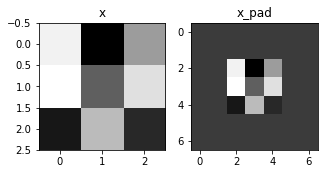

In [7]:
# 单元测试
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_pad[1, 1] =", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

## 2. 单步卷积

过滤器 `3x3`，卷积步长 `1`

<img src="images/Convolution_schematic.gif" style="width:500px;height:350px;">

In [8]:
def conv_single_step(a_slice_prev, W, b):
    '''
    单步卷积

    参数：
    a_slice_prev -- 输入矩阵的一小块数据，维度 (f, f, n_C_prev)
    W -- 权重参数 w，指过滤器，维度 (f, f, n_C_prev)
    b -- 阈值 b，每个过滤器都有一个对应的阈值，维度 (1, 1, 1)

    返回值：
    Z -- 卷积后得到的一个数值，即输出矩阵中的一个元素
    '''

    s = np.multiply(a_slice_prev, W) + b
    return np.sum(s)

In [10]:
# 单元测试

np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -23.16021220252078


## 3. 前向传播

<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>

1. 在python中，通过开始索引和结束索引，可以获取数组中某一区域的元素。例如，如果你想获取一个(5,5,3)矩阵中的左上角的一个2x2的子矩阵，那么你可以使用下面的代码:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```

2. 为了从矩阵中获取一个子矩阵（一小块数据），我们首先需要计算出子矩阵在母矩阵中的坐标，纵向开始索引 `vert_start`, 纵向结束索引 `vert_end`, 横向开始索引 `horiz_start` 和横向结束索引 `horiz_end`。然后就可以用这些索引来定位一个子矩阵，如下图所示。

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">

函数中还会用到如下公式来计算输出矩阵的维度:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{这个是过滤器的个数}$$

In [13]:
def conv_forward(A_prev, W, b, hparameters):
    '''
    卷积网络的前向传播

    参数：
    A_prev -- 本层的输入矩阵，即上一层的输出矩阵，维度 (m, n_H_prev, n_W_prev, n_C_prev)
    W -- 权重，即过滤器，维度 (f, f, n_C_prev, n_C)，n_C 表示过滤器个数
    b -- 阈值，维度 (1, 1, 1, n_C)，一个过滤器配一个阈值
    hparameters -- 超参数步长 s 和 padding 数 p
    '''

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    (f, f, n_C_prev, n_C) = W.shape

    stride = hparameters['stride']  # 步长
    pad = hparameters['pad']        # 填补数量 p

    # 计算输出矩阵的维度 (根据上述公式)
    # 使用 int 实现向下取整
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1

    # 初始化输出矩阵
    Z = np.zeros((m, n_H, n_W, n_C))

    # 给输入矩阵进行零填补
    A_prev_pad = zero_pad(A_prev, pad)

    # 遍历每一个样本
    for i in range(m):
        a_prev_pad = A_prev_pad[i]      # 取出样本 i
        for h in range(n_H):            # 遍历输出矩阵的高
            for w in range(n_W):        # 遍历输出矩阵的宽
                # 计算卷积区域
                vert_start = h * stride
                vert_end = vert_start + f
                horiz_start = w * stride
                horiz_end = horiz_start + f
                a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end]
                for c in range(n_C):    # 遍历过滤器个数
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[..., c], b [..., c])
    
    assert(Z.shape == (m, n_H, n_W, n_C))

    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [14]:
# unit test

np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 1}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]
